In [1]:
%matplotlib inline
import os,random
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
#from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as k
from keras.utils import multi_gpu_model
import tensorflow as tf
from keras.utils import plot_model
from PIL import Image
import cv2
from IPython import display
from tqdm import tqdm
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
img_rows , img_cols = 28 , 28
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols , 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols , 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train =X_train/ 255
X_test  =X_test/ 255

In [3]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [4]:


def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()



In [5]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
shp = X_train.shape[1:]
dropout_rate = 0.25
gopt = Adam(lr=1e-4)
dopt = Adam(lr=1e-3)

## Generator network
nch = 200
inp = Input(shape = (100,))
x = Dense(nch*14*14, kernel_initializer = 'glorot_normal')(inp)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Reshape(target_shape = (14,14,nch))(x)
x = UpSampling2D(size = (2,2))(x)
x = Convolution2D(nch//2 , kernel_size=(3,3) , strides=(1,1) , padding= 'same' , kernel_initializer='glorot_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Convolution2D(1,kernel_size=1,strides=1,padding='same',kernel_initializer='glorot_uniform')(x)
x = Activation('sigmoid')(x)
generator = Model(inputs = inp , outputs = x)
generator.summary()

## Discriminator network

inp = Input(shape = shp)
x = Convolution2D(256 , kernel_size=5 ,strides=5 , padding='same', activation='relu' )(inp)
x = Dropout(dropout_rate)(x)
x = Flatten()(x)
x = Dense(256 , activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(1 , activation='sigmoid')(x)
discriminator = Model(inp , x)
discriminator.compile(loss='binary_crossentropy',optimizer=dopt)
#discriminator.summary()

make_trainable(discriminator , False)

GAN = Model(inputs = generator.input, outputs = discriminator(generator.output))
GAN.compile(loss='binary_crossentropy',optimizer=gopt)
#GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 39200)             3959200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 39200)             156800    
_________________________________________________________________
activation_1 (Activation)    (None, 39200)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 200)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 100)       180100    
__________

In [7]:
ntrain = 10000
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]

noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
generated_images = generator.predict(noise_gen)
X = np.concatenate([XT , generated_images] , axis=0)
n = XT.shape[0]
y = np.zeros([2*n , 1])
y[:n] = 1

print(X.shape , y.shape)

make_trainable(discriminator , True)

discriminator.fit(X , y , epochs = 5 , batch_size=128)

y_hat = discriminator.predict(X)
y_hat[y_hat >= 0.5] = 1
y_hat[y_hat < 0.5] = 0
a = np.count_nonzero(y_hat[:n])/y_hat[:n].shape[0]
b =  np.count_nonzero(y_hat[n:] == 0)/y_hat[n:].shape[0]
print("Accurace for correct data is "+str(a))
print("Accurace for wrong data is "+str(b))

(20000, 28, 28, 1) (20000, 1)
Epoch 1/5
20000/20000 [==============================] - 1s 71us/step - loss: 0.0126
Epoch 2/5
20000/20000 [==============================] - 1s 63us/step - loss: 1.2698e-07
Epoch 3/5
20000/20000 [==============================] - 1s 61us/step - loss: 1.2600e-07
Epoch 4/5
20000/20000 [==============================] - 1s 59us/step - loss: 1.3062e-07
Epoch 5/5
20000/20000 [==============================] - 1s 61us/step - loss: 1.2823e-07
Accurace for correct data is 1.0
Accurace for wrong data is 1.0


In [8]:


# set up loss storage vector
losses = {"d":[], "g":[]}


def train_for_n(nb_epoch=5000 , plt_frq=25 , BATCH_SIZE=32):
    for e in tqdm(range(nb_epoch)):
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        X = np.concatenate((image_batch , generated_images))
        y = np.zeros([2*BATCH_SIZE , 1])
        y[:BATCH_SIZE] = 1
        
        make_trainable(discriminator , True)
        d_loss = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
        
        noise_tr = np.random.uniform(0,1, size = [BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,1])
        y2[:] = 1
        
        make_trainable(discriminator , False)
        g_loss = GAN.train_on_batch(noise_tr , y2)
        losses["g"].append(g_loss)
        
        if e%plt_frq == plt_frq-1:
            plot_loss(losses)
            plot_gen()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

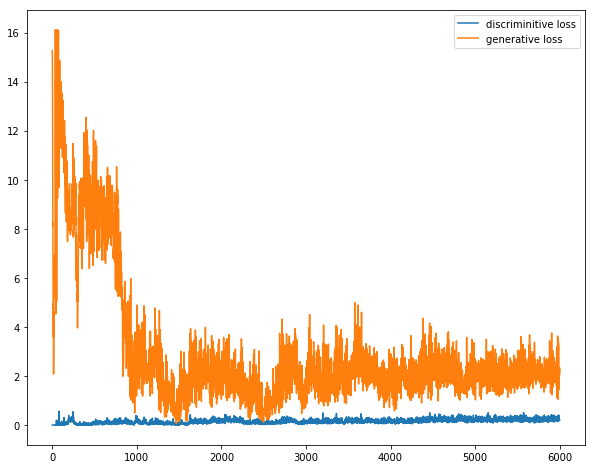

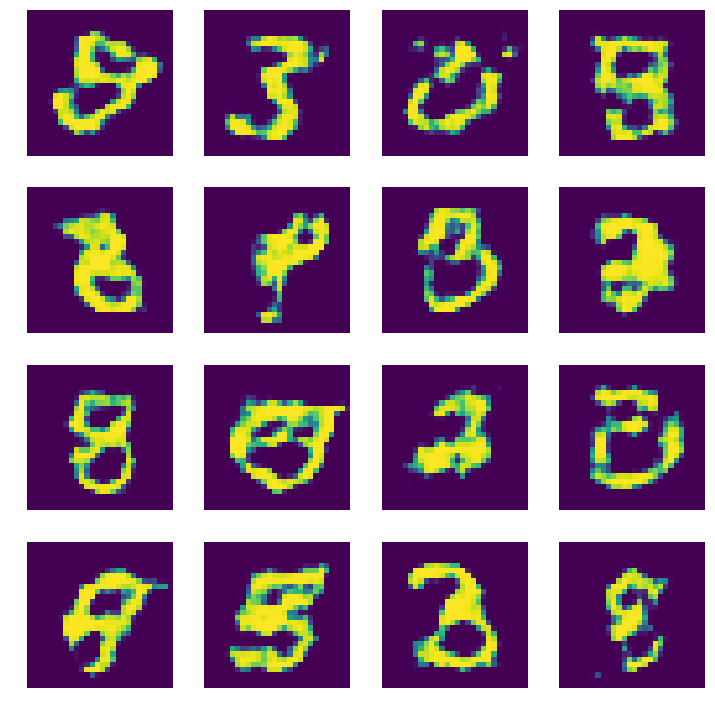

100%|██████████| 6000/6000 [03:14<00:00, 30.84it/s]


In [9]:
train_for_n(nb_epoch=6000, plt_frq=500,BATCH_SIZE=32)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

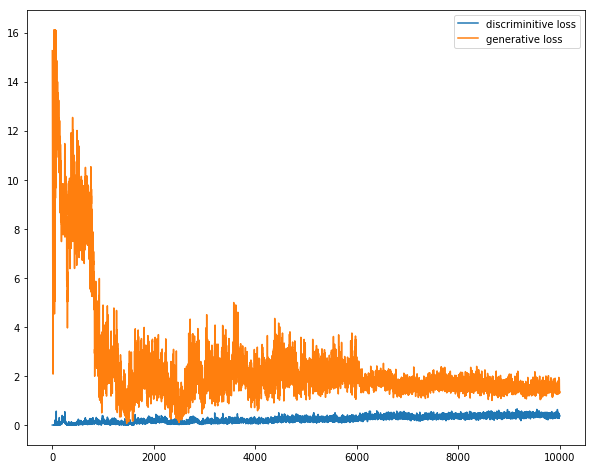

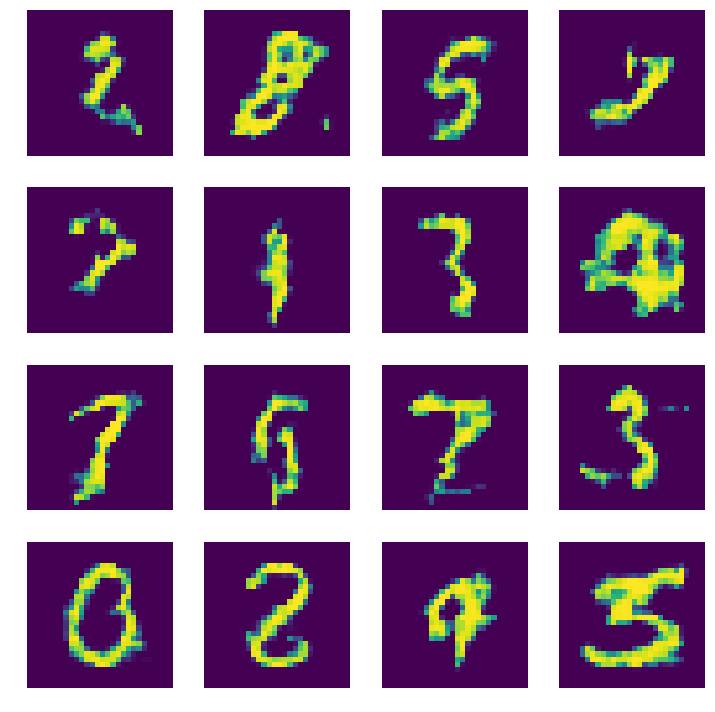

100%|██████████| 2000/2000 [02:12<00:00, 15.07it/s]


In [21]:
k.set_value(discriminator.optimizer.lr , 1e-4)
k.set_value(GAN.optimizer.lr , 1e-4)
train_for_n(nb_epoch=2000, plt_frq=25,BATCH_SIZE=32)